<a href="https://colab.research.google.com/github/AHartNtkn/DS-Unit-2-Regression-Classification/blob/master/module3/DS7_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Fit a linear regression model with multiple features.
- [X] Get mean absolute error for the test set.
- [X] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) instead of Linear Regression, especially if your errors blow up! Watch [Aaron Gallant's 9 minute video on Ridge Regression](https://www.youtube.com/watch?v=XK5jkedy17w) to learn more.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [294]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling
import numpy as np

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# Filter for only family dwellings
df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']

# Convert SALE_DATE to an actual date
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])

# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [0]:
train = df[(1 <= df['SALE_DATE'].dt.month) & (df['SALE_DATE'].dt.month <= 3)].copy()
test  = df[df['SALE_DATE'].dt.month == 4].copy()

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

Why did I make the train/test split before doing exploritory visualizations?

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

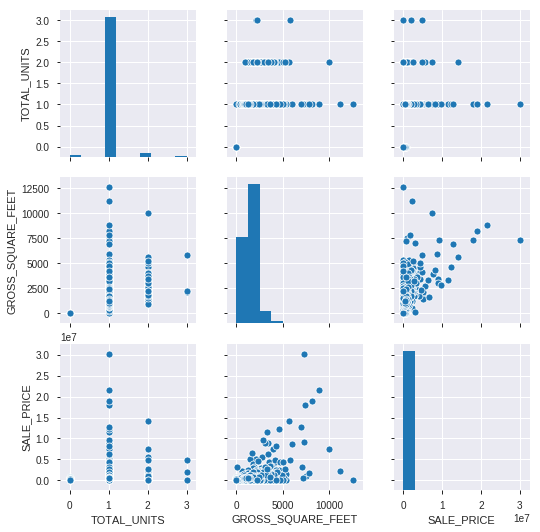

In [301]:
sns.pairplot(df[['TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'SALE_PRICE']]);
plt.show()

In [302]:
df["BOROUGH"].value_counts()

4    2561
5    1082
3     950
2     426
1      42
Name: BOROUGH, dtype: int64

In [303]:
df["NEIGHBORHOOD"].value_counts()

OTHER                      4729
FLUSHING-NORTH              186
EAST NEW YORK                50
BOROUGH PARK                 43
ASTORIA                      24
BEDFORD STUYVESANT           17
UPPER EAST SIDE (59-79)       9
UPPER EAST SIDE (79-96)       3
Name: NEIGHBORHOOD, dtype: int64

In [304]:
df['BUILDING_CLASS_AT_TIME_OF_SALE'].value_counts()

A1    1932
A5    1507
A2     792
A9     364
A0     124
S1     109
A3      99
A4      60
A8      46
A6      21
A7       4
S0       3
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: int64

In [305]:
df['TAX_CLASS_AT_TIME_OF_SALE'].value_counts()

1    5061
Name: TAX_CLASS_AT_TIME_OF_SALE, dtype: int64

The only two attributes which are worth encoding are BOROUGH. The others either will create too many dimensions, or aren't going to be used in my model.

In [307]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(df[['BOROUGH']])
encoded

,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,BOROUGH_1
7,1,0,0,0,0
8,1,0,0,0,0
9,1,0,0,0,0
42,0,1,0,0,0
44,0,1,0,0,0
48,0,0,1,0,0
55,0,0,1,0,0
61,0,0,1,0,0
63,0,0,1,0,0
78,1,0,0,0,0


In [0]:
df = pd.concat([df, encoded], axis=1)

In [0]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,2019-01-01,1,0,0,0,0
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,2019-01-01,1,0,0,0,0
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,2019-01-01,1,0,0,0,0
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,2019-01-01,1,0,0,0,0
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,2019-01-01,1,0,0,0,0


In [0]:
from sklearn.feature_selection import f_regression, SelectKBest

In [0]:
train_nums = train.select_dtypes('number').drop('EASE-MENT', axis=1).dropna()
# train[df.columns[~df.isna().any()]].select_dtypes('number')
test_nums  = test.select_dtypes('number').drop('EASE-MENT', axis=1).dropna()
# test[df.columns[~df.isna().any()]].select_dtypes('number')
assert all(train_nums.columns == test_nums.columns)

In [0]:
target = 'SALE_PRICE'
features = train_nums.columns.drop(target)

ITrain = train_nums[features]
OTrain = train_nums[target]

ITest = test_nums[features]
OTest = test_nums[target]

In [0]:
selector = SelectKBest(score_func=f_regression, k=3)

In [333]:
ITrain_selected = selector.fit_transform(ITrain, OTrain)
ITest_selected = selector.transform(ITest)
ITrain_selected.shape, ITest_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((4094, 3), (967, 3))

In [334]:
# Which features were selected?
all_names = ITrain.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)
    
print('\nFeatures not selected:')
for name in unselected_names:
    print(name)

Features selected:
BLOCK
GROSS_SQUARE_FEET
BOROUGH_1

Features not selected:
LOT
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE
BOROUGH_2
BOROUGH_3
BOROUGH_4
BOROUGH_5


In [335]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

features = selected_names
target = ['SALE_PRICE']

model = LinearRegression()
model.fit(train_nums[features],train_nums[target])

testMAE = mean_absolute_error(test_nums[target], model.predict(test_nums[features]))

print(f'Test MAE: ${testMAE:,.0f}')

Test MAE: $388,953


In [336]:
print(f'Mean Prices: ${df["SALE_PRICE"].mean():,.0f}')

Mean Prices: $471,842


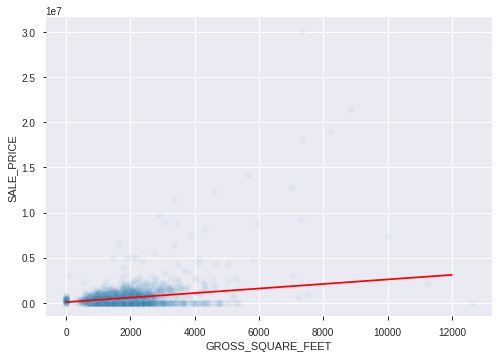

In [338]:
sns.scatterplot(df['GROSS_SQUARE_FEET'], df['SALE_PRICE'], alpha=.05)

x = np.array(range(12000))
y = x * model.coef_[0,1] + model.intercept_

plt.plot(x,y, color='r')

It's not wrong, but this is an awful fit.